# Homework 3
Eric Gagliano (egagli)

## Problem 1

Download and work through the non-parametric tests notebook. Read the documentation and source code for the scipy.stats.ranksums and scipy.stats.mannwhitneyu functions. Then answer the following questions:

### A. What assumptions about our data or the hypothesis test are these functions making?

These functions make the assumption that our data is independent and continuous. The data should be in an N-d array. This data is NOT assumed to be normally distributed. 

### B. Are there any additional inputs/options we need to specify to make sure that they duplicate our results above?

Yes, for the Mann-Whitney U test we need to specify whether we want to use a continuity correction and how we deal with ties. With both tests we need to specify the alternate hypothesis in order to replicate our results (in practice this multiplies our p-value by 2 if we do a two sided test). (The input parameters are different depending on which release of scipy we have, and old version is used in this environment that does not contain all the features in the current documentation.)

### C. Revisit Homework 2 part D, using the observations of peak flow data for the Sauk River to try and detect a change in streamflow around 1977. Perform the rank-sum test from Homework 2 part D again using the fuction(s) and options you identified here in part B. Discuss any differences in the test results that arise from slight differences in these two functions and the options you can choose.

In [1]:
#import all required modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# reading in data
Sauk_data_file = 'Sauk_peak_WY1929_2017.xlsx'
Sauk_data = pd.read_excel(Sauk_data_file,header=6)
Sauk_data = Sauk_data[1:]
Sauk_data['peak_va'] = Sauk_data['peak_va'].astype('int64')
Sauk_data_before_1977 = Sauk_data[Sauk_data['water_year']<1977]
Sauk_data_after_1977 = Sauk_data[Sauk_data['water_year']>=1977]

/opt/conda/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
# run to find out parameters of our function, these are different than the current documentation because of different releases
#help(stats.ranksums)
#help(stats.mannwhitneyu)

In [4]:
# calculate ranksums
z_wilcoxan, p_wilcoxan = stats.ranksums(Sauk_data_after_1977['peak_va'], Sauk_data_before_1977['peak_va'])
print(f'Z from stats.ranksums: {z_wilcoxan:.4}')
print(f'p from stats.ranksums: {p_wilcoxan:.4}')

Z from stats.ranksums: 2.497
p from stats.ranksums: 0.01251


In [5]:
# calculate mannwhitneyu with continuity correction
u_mwu1, p_mwu1 = stats.mannwhitneyu(Sauk_data_after_1977['peak_va'], Sauk_data_before_1977['peak_va'],alternative='two-sided')
print(f'U from stats.mannwhitneyu: {u_mwu1:.4}')
print(f'p from stats.mannwhitneyu: {p_mwu1:.4}')

U from stats.mannwhitneyu: 1.376e+03
p from stats.mannwhitneyu: 0.01265


In [6]:
# calculate mannwhitneyu without continuity correction
u_mwu2, p_mwu2 = stats.mannwhitneyu(Sauk_data_after_1977['peak_va'], Sauk_data_before_1977['peak_va'],alternative='two-sided',use_continuity=False)
print(f'U from stats.mannwhitneyu: {u_mwu2:.4}')
print(f'p from stats.mannwhitneyu: {p_mwu2:.4}')

U from stats.mannwhitneyu: 1.376e+03
p from stats.mannwhitneyu: 0.01251


The test results are identical when we use a thoughtful choice of options. For instance, with the continuity correction, the Mann-Whitney U test yields a similar p-value (but not exactly the same p-value as the Rank Sums test). However, when we do not use the continuity correction, we get the exact same p-value for both tests.

## Problem 2

For this problem, consider only differences between watershed 1 (WS1) and watershed 2 (WS2). These two watersheds are adjacent to each other in the HJ Andrews Experimental Forest. We want to test if there was a change in streamflow due to the forest within WS1 being completely clearcut (starting late 1962 and completed in 1966). Because the two watersheds are adjacent, we can expect that they experience the same storms leading to peak runoff (so we won't be considering any differences due to different precipitation amounts or timing).

Here we want to test whether the difference in peak flows between WS1 and WS2 is statistically different for four different time periods:

| Time Period | Years |Index12 “treatment” label| Notes |
|----|------|---|-----|
|control period	|1953-1962	|1	|before any clearcutting in WS1|
|active clearcutting|	1963-1966	|2	|during clearcutting of WS1|
|0-15 years after clearcutting	|1967-1981|	3	|WS1 forest starts to recover|
|\>15 years after clearcutting	|1982-2015|	4	|WS1 forest recovering further|

We want to know whether the four periods are statistically different from each other, and if so, which one or ones are statistically different from which other ones.

### A. First, plot the timeseries of the streamflow measurements as a function of water year for both watershed 1 and watershed 2 on the same graph. Use vertical dashed lines (axvline in matplotlib) to indicate the different periods (put a vertical dashed line in 1963, in 1967, and in 1982).

In [7]:
# read in data
HJAndrews_data_file = 'HJAndrews_peakflow_WS1_WS2_WS3.xlsx'
HJAndrews_data = pd.read_excel(HJAndrews_data_file,header=2)

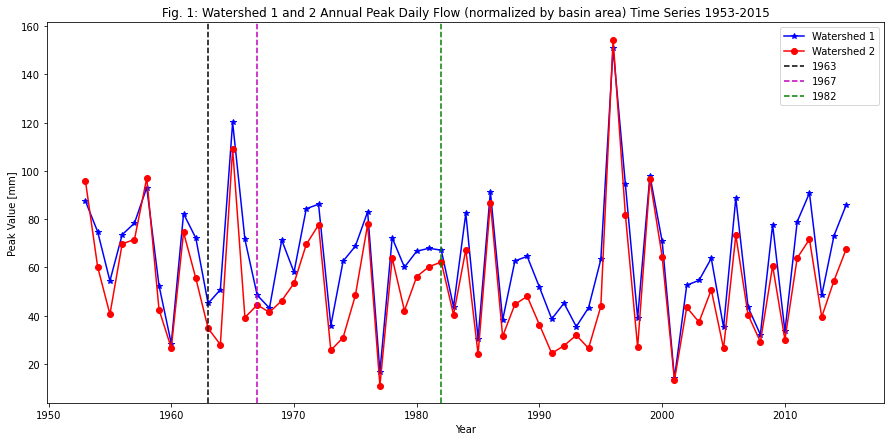

In [8]:
# create time series plot from imported data
f,ax = plt.subplots(figsize=(15,7))
ax.plot(HJAndrews_data['Water Year'],HJAndrews_data['Watershed 1'],'b-*',label='Watershed 1')
ax.plot(HJAndrews_data['Water Year'],HJAndrews_data['Watershed 2'],'r-o',label='Watershed 2')
ax.axvline(1963, color='black', linestyle='--', label=f'1963')
ax.axvline(1967, color='m', linestyle='--', label=f'1967')
ax.axvline(1982, color='g', linestyle='--', label=f'1982')
ax.legend()
ax.set_title('Fig. 1: Watershed 1 and 2 Annual Peak Daily Flow (normalized by basin area) Time Series 1953-2015')
ax.set_xlabel('Year')
ax.set_ylabel('Peak Value [mm]');

### B. It has been suggested that paired data such as this can be made to be closer to normally distributed by taking the log of each value before subtracting. Create two datasets: Q12 = streamflow1 - streamflow2 and Qlog12 = log(streamflow1)- log(streamflow2) and make graphs to demonstrate which is closer to normally distributed. Given that we want to use an ANOVA analysis, explain why is it important to do a transformation to get the data closer to normally distributed?

In [9]:
# create new datasets for difference and difference of log values
HJAndrews_data['Q12'] = HJAndrews_data['Watershed 1'] - HJAndrews_data['Watershed 2']
HJAndrews_data['Qlog12'] = np.log(HJAndrews_data['Watershed 1']) - np.log(HJAndrews_data['Watershed 2'])

Text(0, 0.5, 'Probability of Occurance')

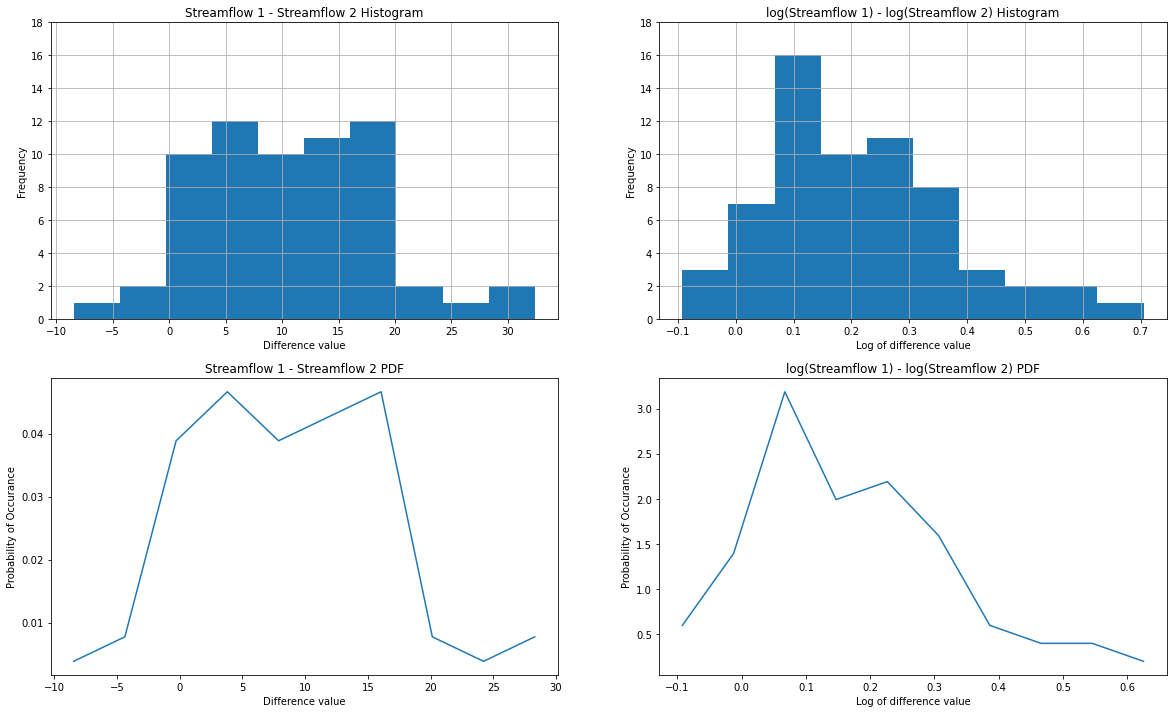

In [10]:
# make graphs to see which is closer to normal distribution
f,ax= plt.subplots(2,2,figsize=(20,12))
HJAndrews_data['Q12'].hist(ax=ax[0,0],bins=10)
HJAndrews_data['Qlog12'].hist(ax=ax[0,1],bins=10)
counts1, bin_edges1 = np.histogram(HJAndrews_data['Q12'],bins=10,density=True)
counts2, bin_edges2 = np.histogram(HJAndrews_data['Qlog12'],density=True,bins=10)
ax[0,0].set_ylim((0,18))
ax[0,1].set_ylim((0,18))
ax[1,0].plot(bin_edges1[:-1],counts1)
ax[1,1].plot(bin_edges2[:-1],counts2)
ax[0,0].set_title('Streamflow 1 - Streamflow 2 Histogram')
ax[0,1].set_title('log(Streamflow 1) - log(Streamflow 2) Histogram')
ax[1,0].set_title('Streamflow 1 - Streamflow 2 PDF')
ax[1,1].set_title('log(Streamflow 1) - log(Streamflow 2) PDF')
ax[0,0].set_xlabel('Difference value')
ax[0,1].set_xlabel('Log of difference value')
ax[1,0].set_xlabel('Difference value')
ax[1,1].set_xlabel('Log of difference value')
ax[0,0].set_ylabel('Frequency')
ax[0,1].set_ylabel('Frequency')
ax[1,0].set_ylabel('Probability of Occurance')
ax[1,1].set_ylabel('Probability of Occurance')

It is important to get our data as close to normally distributed as possible because ANOVA, like the t-test, assumes a normal distribution of residuals from the mean. If we don't meet the assumptions of a test, we risk having meaningless results and/or improperly analyzing the results. To me, it looks like the data that is not log transformed is more normal.

## C. State the null and the alternative hypothesis for the question of whether the four periods are statistically different from each other. State the type I error (alpha value) that you are willing to accept.

$H_0$: The difference in peak flows of the four periods all have the same mean.

$H_a$: The difference in peak flows of the four periods do not have the same mean.

The type I error would be rejecting the null hypothesis and saying the four periods are statistically different when in fact they are not. Let's say we want 95% confidence, so in this case we accept a 5\% chance of type I error with an $\alpha = 0.05$.

## D. Perform an ANOVA test and discuss the results, related both to your hypothesis test listed above and to the more detailed question of which groups are statistically different from which other groups. Include graphs and/or tables that illustrate your results, and be sure to discuss what they mean. When using these ANOVA and other statistics functions, be sure that you understand what the code is doing (especially the defaults that different functions use) and outputting.

In [11]:
# let's take a look at the data
HJAndrews_data

,Water Year,Watershed 1,Watershed 2,Watershed 3,Index12,Index23,Q12,Qlog12
0,1953,87.5495,96.0073,81.9364,1,1,-8.4578,-0.092220
1,1954,74.7993,60.2205,50.7975,1,1,14.5788,0.216796
2,1955,54.4041,40.5364,35.1773,1,1,13.8677,0.294239
3,1956,73.5548,69.7704,54.6327,1,1,3.7844,0.052821
4,1957,78.3552,71.5483,57.1218,1,1,6.8069,0.090880
...,...,...,...,...,...,...,...,...
58,2011,78.9393,63.8525,59.9919,4,4,15.0868,0.212103
59,2012,90.8260,71.6753,65.6812,4,4,19.1507,0.236799
60,2013,48.3592,39.4697,38.5299,4,4,8.8895,0.203123
61,2014,73.1484,54.5057,50.9245,4,4,18.6427,0.294185


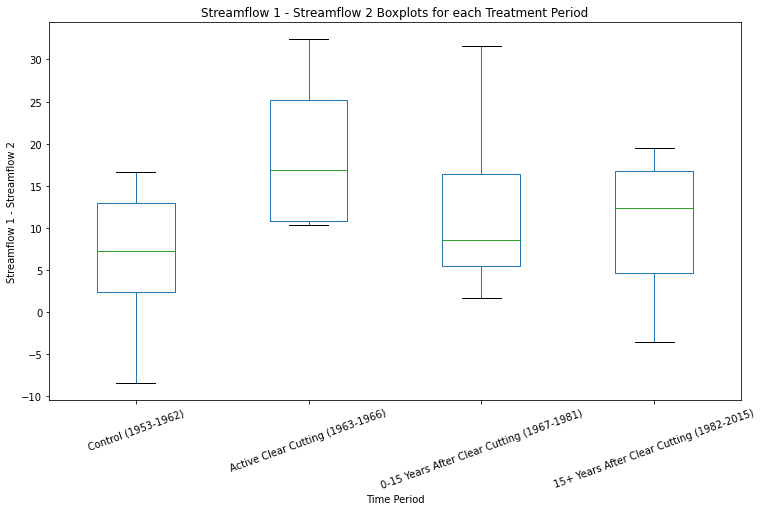

In [12]:
# Using boxplot, we can start to visually see differences between the treatment groups
f,ax=plt.subplots(figsize=(12,7))
box = HJAndrews_data.boxplot(ax=ax,column=['Q12'],by=['Index12'], grid=False)
ax.set_xlabel('Time Period')
ax.set_ylabel('Streamflow 1 - Streamflow 2')
ax.set_title('Streamflow 1 - Streamflow 2 Boxplots for each Treatment Period')
plt.xticks([1, 2, 3, 4], ['Control (1953-1962)', 'Active Clear Cutting (1963-1966)', '0-15 Years After Clear Cutting (1967-1981)','15+ Years After Clear Cutting (1982-2015)'],rotation=20)
plt.suptitle('');

In [13]:
# ANOVA calculation
fvalue, pvalue = stats.f_oneway(HJAndrews_data['Q12'].loc[HJAndrews_data['Index12']==1], 
                                HJAndrews_data['Q12'].loc[HJAndrews_data['Index12']==2], 
                                HJAndrews_data['Q12'].loc[HJAndrews_data['Index12']==3], 
                                HJAndrews_data['Q12'].loc[HJAndrews_data['Index12']==4])
print(f'The one way ANOVA test yields a test statistic of {fvalue:.4} and a p-value of {pvalue:.4}.')

The one way ANOVA test yields a test statistic of 2.868 and a p-value of 0.04403.


Since our p-value (0.044) $<$ $\alpha$ (0.05), we must reject our null hypothesis. We can say that with 95\% confidence that the peak flow means are indeed different for the four given time periods.

Let's confirm this by using the second method discussed in lab3-1:

In [14]:
# Ordinary Least Squares (OLS) model
model = ols('Q12 ~ C(Index12)', data=HJAndrews_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# display the results table
print(anova_table)

                 sum_sq    df         F    PR(>F)
C(Index12)   494.857606   3.0  2.867861  0.044027
Residual    3393.539593  59.0       NaN       NaN


These results confirm our previous test. Notice how the ANOVA table lists an almost identical (after rounding) F statistic and p-value. Now for the Tukey Pairwise Test:

In [15]:
# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=HJAndrews_data['Q12'], groups=HJAndrews_data['Index12'], alpha=0.05)

# display the results table
print(m_comp)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2  12.8226 0.0292   0.9601  24.685   True
     1      3    5.498 0.2953  -2.6879 13.6839  False
     1      4   4.3973  0.381  -2.8159 11.6105  False
     2      3  -7.3246 0.3246  -18.608  3.9589  False
     2      4  -8.4253 0.1647 -19.0242  2.1737  False
     3      4  -1.1007    0.9  -7.3159  5.1145  False
-----------------------------------------------------


Digging into the details, here we learn that individually, the only time periods with significant difference in means is between group 1 and 2: the control period (1953-1962) and the active clear cutting period (1963-1966). Therefore, we reject the null hypothesis that period 1 and 2 have the same difference in mean peak flows. We fail to reject the null hypothesis that every other individual combination of time period groups have the same difference in mean peak flows.

# References

Note: A large amount of this code is adapted from the CEWA 565 course materials, predominantly from the lab 3 jupyter notebook which can be found in module 3 of the class website: https://mountain-hydrology-research-group.github.io/data-analysis/modules/module3.html